In [1]:
import shutil
import os
import numpy as np
import fastai
from fastai import *
from fastai.vision.all import *
from fastai.imports import *
from fastai.vision import *
from fastai.metrics import *

from fastai.vision.all import *


# Data Import

In [3]:
# Splitting training data into train/validation by sub-folders so we can automatically create labels

train_data_path = 'data/train_kaggle'

image_paths = get_image_files(train_data_path)
print(image_paths[:5])

[Path('data/train_kaggle/chili-dog_7861.jpg'), Path('data/train_kaggle/people_4029.jpg'), Path('data/train_kaggle/food_6411.jpg'), Path('data/train_kaggle/hotdog_9239.jpg'), Path('data/train_kaggle/people_4983.jpg')]


In [4]:
# settings

model = models.resnet50
WORK_DIR = os.getcwd()
image_size=299
batch_size=16

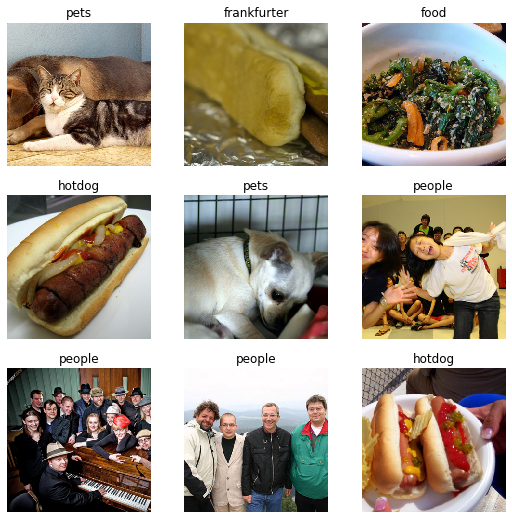

In [12]:
# get_transform is the default image transformer 
# get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10.0, max_zoom:float=1.1, max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75, p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None) → Collection[Transform]

data = ImageDataLoaders.from_name_re(path=train_data_path,
                                   fnames=image_paths, 
                                   pat=r'([^/]+)_\d+\.jpg$', 
                                   valid_pct=0.2,
                                   ds_tfms=aug_transforms(), 
                                   test='data/test_kaggle', 
                                   bs=batch_size,
                                   num_workers=0,
                                   seed=42,
                                   item_tfms=Resize(image_size),
                                   batch_tfms=Normalize.from_stats(*imagenet_stats))
data.show_batch()

In [13]:
# creates a Learner: an abstraction connecting a model, an optimizer, and the data to train it on — and automatically chooses an appropriate loss function.For this example the learner, we will:
# Automatically download an ImageNet pretrained model
# Remove the classification head of the model
# Replace it with a head appropriate for this particular dataset
# Set appropriate defaults for the optimizer, weight decay, learning rate, and other hyperparameters (users can override the defaults as well)
learn = cnn_learner(data, model, metrics=accuracy, model_dir=WORK_DIR)

In [14]:
# learn.fine_tune(4)
# The fifth line fine-tunes the model using the 1-cycle policy: a recent best practice for training neural networks. There are a lot of things happening here:
# Annealing both learning rates and momentums
# Printing metrics on the validation set
# Displaying results in an HTML or console table
# Recording losses and metrics after every batch
# A GPU will be used if available: it will first train the head for one epoch while the body of the model is frozen, then fine-tune as many epochs given (there are four here), using discriminative learning rates.

learn.fine_tune(4) 

epoch,train_loss,valid_loss,accuracy,time
0,0.890104,0.568331,0.806522,41:05


epoch,train_loss,valid_loss,accuracy,time
0,0.716062,0.554586,0.818478,51:49
1,0.600045,0.622993,0.794565,51:55
2,0.324534,0.458158,0.840217,2:02:05
3,0.197309,0.489879,0.827174,51:55


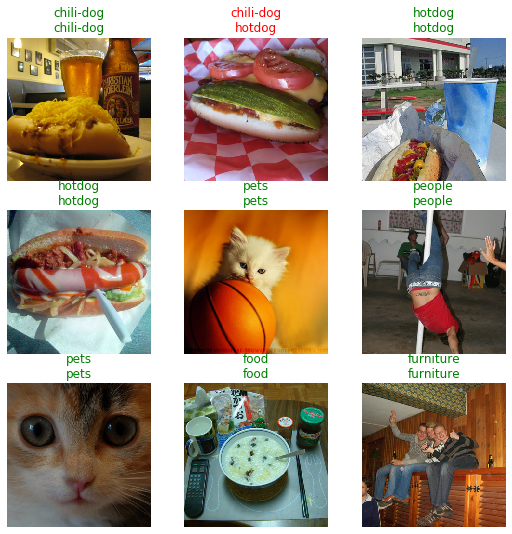

In [17]:
# look at test results for a random set of files
learn.show_results()

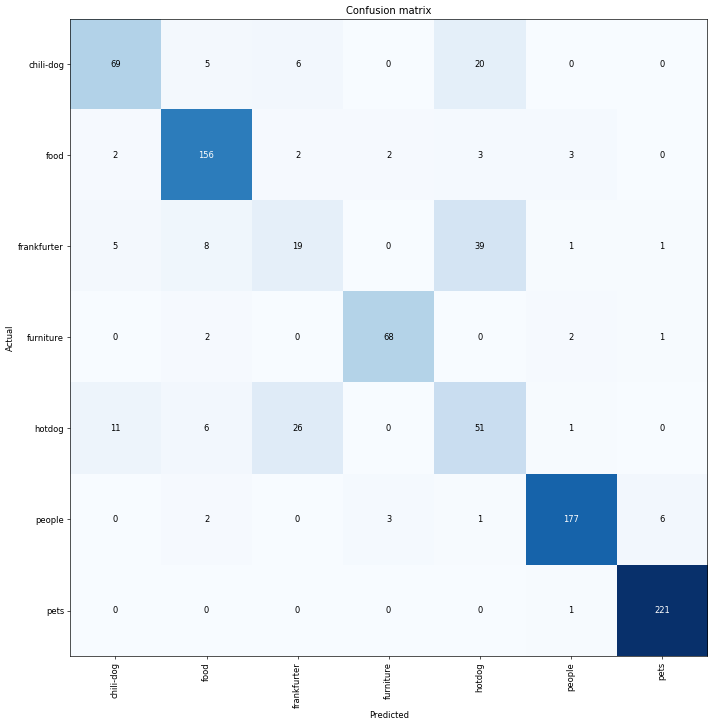

In [22]:
# calculate and plot confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

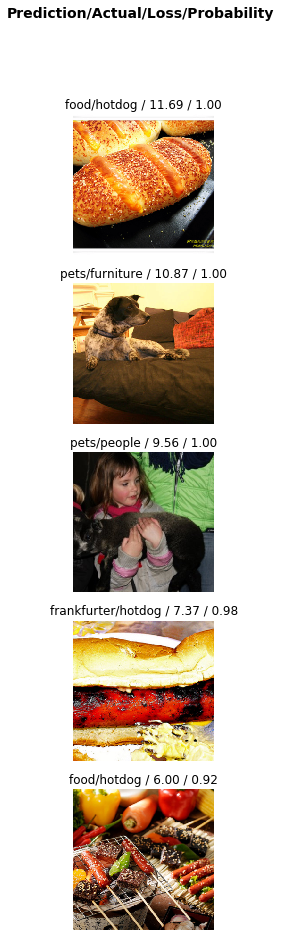

In [20]:
# plot top losses for wrong predictions with high confidence
interp.plot_top_losses(5, nrows=5)

In [32]:
# export model file
learn.path = Path(os.getcwd())
learn.export()

In [87]:
# predict on test set

test_data_path = 'data/test_kaggle'
test_img = get_image_files(train_data_path)

test_dl = learn.dls.test_dl(test_img)
pred_tensor, ignored, preds = learn.get_preds(dl=test_dl, with_decoded=True)


In [151]:
# create submission file
dict_label_order = {order: label for order,label in enumerate(learn.dls.vocab)}
prediction = [dict_label_order[x.item()] for x in preds] 
fn = [str(f).rsplit('/',1)[1] for f in test_dl.items]
pred_df = pd.DataFrame({'image_id': fn, 'prediction':prediction})
pred_df['label'] = np.where(pred_df['prediction'].isin(['frankfurter', 'chili-dog', 'hotdog']), 1, 0 )
pred_df[['image_id', 'label']].to_csv('sumbmission.csv', index=False)